# Bayesian Optimisation Overview

# Contents
1. [Introduction to Probaballistic Machine Learning](#pml_introduction)
    1. [Bayes Rule](#br)
    2. [Non-probabillistic approach](#npba)
    3. [Making Bayesian Predictions](#bpred)
2. [Gaussian Processes](#gp)
    1. [Introduction to GPs](#gp_intro)
    2. [Sampling from a GP](#samples)
    3. [Posterior samples](#post_samples)
3. [Training LDA](#train_lda)
    1. [Gibbs Sampling](#gibbs)
    2. [Collapsed Gibbs Sampling for LDA](#cgibbs)
    3. [Variational Inference](#vi)
    4. [Online Variational Inference for LDA](#ovi)
    
4. [Topic evaluation](#te)
5. [References](#ref)

## Introduction to Probabilistic Machine Learning <a name="introduction"></a>

Recently, due to the increasing need to reliably quantify the unceratinty of predictions in the machine learning algorithms, there has been a vast increase in popularity of Probabilistic Models, in both academia and industry. The specific examples of applications include:

* Topic Models (LDA, HDP, Deep Exponential Families);

* Bayesian Neural Networks;

* Gaussian Process Models 

This tutorial is focused on a particular application of the Gaussian Process Model - Bayesion Optimisation. We first introduce some key mathematical ideas involved in carrying out Bayesian Inference. Later, introduce the idea of Gaussian Processes and, in particular their application in optimisation of complex Black Box functions. 

### Bayes Rule <a name="br"></a>
In order to provide a more comprehensive review of the probabilistic modelling, let us address several key mathematical concepts.

Let two $A$ and $B$ two events, then the `joint` probability of two events is given by

$$P(A,B) = P(A|B)P(B) = P(B|A)P(A),$$

which, when rearranged leads to the following identity, also known as the Bayes Rule,

$$ P(A | B) = \frac{P(B | A) \cdot P(A)}{P(B)}. $$

### Bayes Rule
The Bayes Rule is the cornerstone of most probabilistc models. In order to understand its signifince, let $A$ represent a parameter $w$ of a given model and $B$ represent the data $D$ used for training. The Bayes Rule thus can be re-written as

$$ P(w | D) = \frac{P(D | w) \cdot P(w)}{P(D)}, $$
where 
* $P(w)$ is the prior distribution, which represents the probability of observing parameters values $w$ of the given model. Conceptually, prior distribution reflects someone's existing knowledge about the value of a given parameter.

* $P(D | w)$ is the likelihood function, which represent the probabiliity of oberving the data $D$, conditional on the parameter values $w$ of the model. The likelihood reflects fitting model to the data.

* $P(D)$ is the evidence, the probability of observing the data, which can be expressed as $\int P(D | w) \cdot P(w) dw$ in the continuous case by integrating out the paramter values.

* $P(w | D)$ is the posterior distibution, which represents probability of observing the parameter values $w$ of the given model, conditional on the data $D$. 

### Making Bayesian Predictions<a name="bpred"></a>

In order to make predictions in a Bayesian setting, we wish to determine the probability distribution of new data $D'$, given train data $D$. Using the posterior distribution, the posterior predictive can be written as

$P(D' | D) = \int P(D' | w) \cdot P(w | D) dw$ .

In other words, the expected probability of observing the new data, given the model parameters, weighted with the respect to the posterior distribution.

### Non-probabillistic approach<a name="npba"></a>

The traditional statistical methods focus on optimising the value of the likelihood function for paramter values 

$$L = argmax_w(P(D|w)), $$

resulting om point estimates for parameteres values.  Evaluating the posterior allows to obtain the probability distribution of the parameters rather than just point estimates, thus providing a more complete representation of the underlying physical process and allowing to quantify the uncertainty of predictions. Having said that, evaluating the posterior tends to be much harder than computing likelihood, and, often not possible analytically. 

## Gaussian Processes<a name="gp"></a>

Here we describe at a high level the concept of Gaussian Processes. For a more complete overview of the topic please refer to http://www.gaussianprocess.org/gpml/chapters/RW.pdf.

### Introduction to GPs<a name="gp_intro"></a>

'A Gaussian process is a collection of random variables, anyfinite number of which have a joint Gaussian distribution'.  

A GP is specified by its mean

$m(x) = E[f(x)]$ (usually set to 0),

and covariance

$k(x, x') = E[(f(x)-m(x))(f(x)-m(x)]$.

The real process  therefore is distruted

$f(x) \sim GP(m(x), k(x,x'))$.

### Intrduction to GPs

In reality, we consider a finite number of datapoints $X$. Given $f(x)$, any collection of values $f(x_i)$ is jointly Gaussian, i.e.

$f(X) \sim N(0, K(X,X))$.

The key part of sampling from a Gaussian Process is chosing the kernel function. Displayed below are several common choices of the kernel: Linear, Periodic and Squared Exponential.

In [3]:

import numpy as np
import matplotlib.pyplot as plt
    
def linear_kernel(x1,
                  x2,
                  sd = .1,
                  offset = 11.):
    """
    Linear kernel ref
    """
    return sd**2 * np.multiply.outer((x1-offset),(x2-offset))  

def squared_exponential_kernel(x1,
                               x2,
                               sd = 1.,
                               lengthscale = .1):
    """
    Squared exponential kernel ref
    """
    return sd**2 * np.exp(-(np.subtract.outer(x1,x2)**2)/(2*lengthscale**2))

def periodic_kernel(x1,
                    x2,
                    sd = 1.,
                    lengthscale = 1.,
                    period = 1.):
    """
    Periodic kernel ref
    """
    return sd**2 * np.exp(-2*(np.sin(np.pi*abs(np.subtract.outer(x1,x2))/period)**2)/(lengthscale**2))

def plot_kernel(kernel, domain_vals, params):
    """
    Visualise the kernel (matrix and )
    """

    plt.plot(domain_vals, kernel(domain_vals, np.zeros(len(domain_vals)), **params))
    plt.show()

    plt.imshow(kernel(domain_vals, domain_vals, **params))
    plt.show()

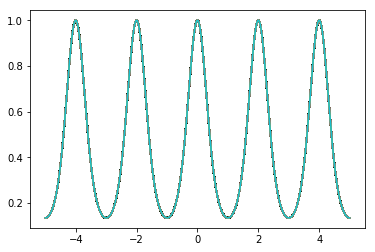

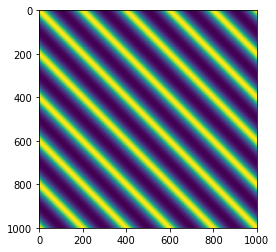

In [4]:
data = np.linspace(-5, 5, 1000)
plot_kernel(periodic_kernel, data, {"sd": 1., "lengthscale": 1., "period": 2.})

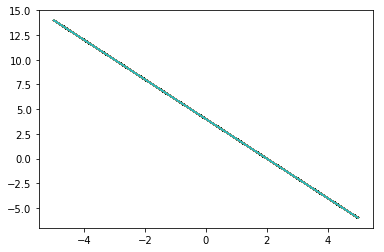

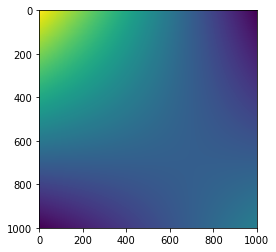

In [9]:
plot_kernel(linear_kernel, data, {"sd": 1., "offset": 2.})

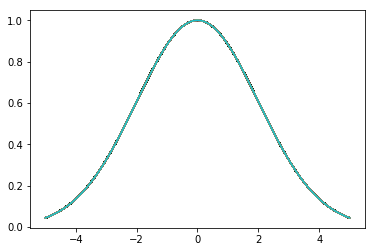

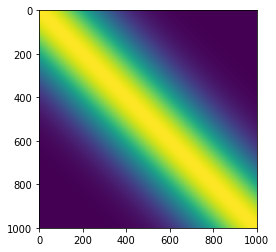

In [12]:
plot_kernel(squared_exponential_kernel, data, {"sd": 1., "lengthscale": 2})

In [1]:
def generate_gp(kernel, hyper_params, data, num_realisations):
    
    """
    Generate a series of draws from a GP to be used as prior
    """
    realisations = []
    data_dim = len(data)
    mean = np.zeros(data_dim)
    covariance = kernel(data, data, **hyper_params)
    realisations = np.random.multivariate_normal(mean, covariance, num_realisations)
    return realisations

### Sampling from a GP<a name="samples"></a>

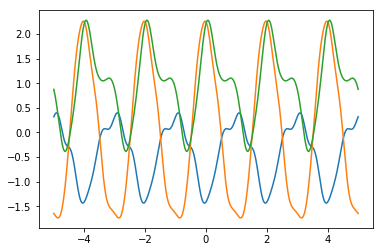

In [15]:
# Periodic kernel
realisations = generate_gp(periodic_kernel, {"sd": 1., "lengthscale": 1., "period": 2.}, data, 3)
for realisation in realisations:
    plt.plot(data, realisation);
plt.show()

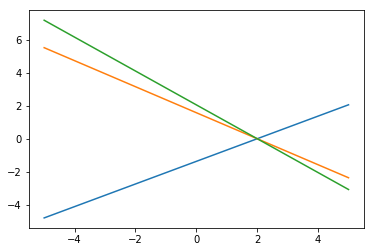

In [25]:
# Linear kernel
realisations = generate_gp(linear_kernel, {"sd": 1., "offset": 2.}, data, 3)
for realisation in realisations:
    plt.plot(data, realisation);
plt.show()

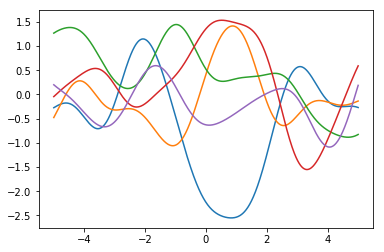

In [26]:
# Squared Exponential
realisations = generate_gp(squared_exponential_kernel, {"sd": 1., "lengthscale": 1.}, data, 5)
for realisation in realisations:
    plt.plot(data, realisation);
plt.show()

### Posterior samples <a name="post_samples"></a>

Suppose we observe some data $\{X,y\}$ and assuming that $y$ has been corrupted with Gaussian distributed additive noise $\epsilon$. The model of $y$ is

$y = f(X) + \epsilon$.

In order to make predictions at new points $X^\ast $, we need to calculate the posterior predictive distribution. However, due to the properties of a Gaussian, the (usually non-trivial) integral becomes easy to compute and the  desired dsitribution is also Gaussian:

$p(y^\ast | X^\ast, X, y)  \sim N(y^\ast| K(X^\ast, X)[K(X, X) + \epsilon \mathbb{I}]^{-1}y, K(X^\ast, X^\ast) - K(X^\ast, X)[K(X, X) + \epsilon \mathbb{I}]^{-1}K(X, X^\ast)$

In [61]:
def gp_posterior(kernel, hyper_params, x_train, y_train, eval_points, noise = .05):
    """
    Calculate the posterior mean and covariance of a GP.
    
    :param kernel: type of kernel used
    :param hyper_params: hyper parameter kernel values
    :param x_train: X values observed
    :param y_train: Y values observed
    :param eval_points: Test data for GP
    :param noise: level of data corruption
    
    :return: mean, covariance
    """
    temp = np.dot(kernel(eval_points, x_train, **hyper_params), np.linalg.inv(kernel(x_train, x_train, **hyper_params)
                                                                              + noise*np.eye(len(x_train)))) 
    
    mean = np.dot(temp, y_train.T)
    
    cov = kernel(eval_points, eval_points, **hyper_params) - np.dot(temp, kernel(x_train, eval_points, **hyper_params))
    
    return mean, cov

In [62]:
x_s = np.array([-2.5, 0, 2.5])
y_s = np.random.randn(len(x_s)) * 2
f_min = min(y_s)
mean,cov = gp_posterior(kernel = squared_exponential_kernel,
                        hyper_params = {"sd": 1., "lengthscale": 2.},
                        x_train = x_s,
                        y_train = y_s,
                        eval_points = data, 
                        noise = 0)

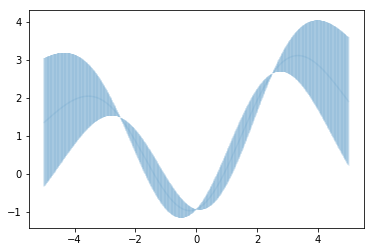

In [70]:
plt.errorbar(data, mean, yerr=np.sqrt(cov.diagonal())*1.96, alpha = .1);plt.show()


### Bayesian Optimisation

In [ ]:
### Acquisition Functions

In [64]:
from scipy.stats import multivariate_normal
from scipy.stats import norm
var = cov.diagonal()

-0.005005005005005003


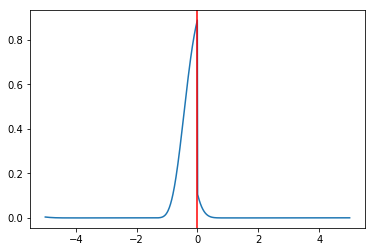

In [71]:
acq_ = [norm.cdf((f_min - m)/np.sqrt(v)) for m,v in zip(mean, var)]
largest_x = np.where(acq_ == max(acq_))[0][0]
print(data[largest_x])


plt.plot(data, [norm.cdf((f_min - m)/np.sqrt(v)) for m,v in zip(mean, var)]); 
plt.axvline(x = data[largest_x], c = 'r')
plt.show()



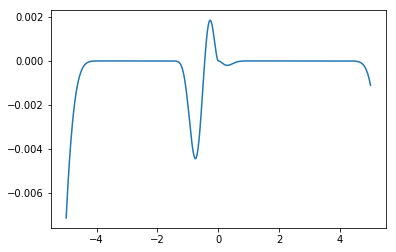

In [66]:
mu = [max(0, f_min - mean[i]) for i in range(len(data))]
plt.plot(data, [(v*(((f_min - m)/np.sqrt(v))*norm.cdf((f_min - m)/np.sqrt(v)) + .1*norm.pdf((f_min - m)/np.sqrt(v)))) for m,v in zip(mean, var)]); plt.show()





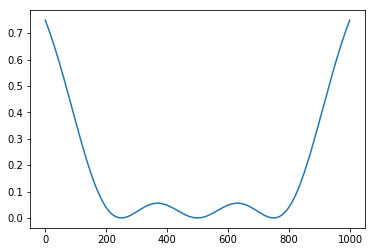

In [68]:
plt.plot(cov.diagonal())

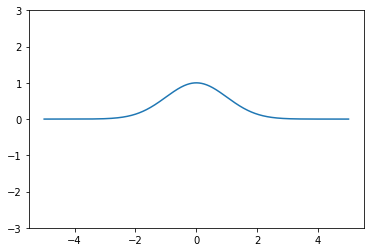

In [291]:
plt.plot(data, mean);
plt.ylim(-3,3)
plt.show()

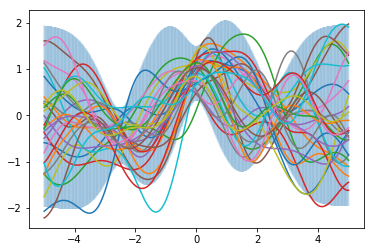

In [324]:
for i in range(30):
    mean, cov, post = noisy_posterior(squared_exponential_kernel, { "sd": 1., "lengthscale": -1.}, np.array([-2.5,0, 2.5]), 20, data, np.array([-.5,1, 0]))
    plt.plot(data, post.flatten());
plt.errorbar(data, mean, yerr=np.sqrt(cov.diagonal())*1.96, alpha = .1)
plt.show()

In [88]:
def acquisition_function(option = "MPI"):
    if option == "MPI":
        pass
    elif option == "EI":
        raise NotImplementedError
    elif option == "LCB":
        raise NotImplementedError

SyntaxError: unexpected EOF while parsing (<ipython-input-88-8caa249f5062>, line 1)

In [313]:
np.stack(cov.diagonal(), -cov.diagonal()).shape

TypeError: only length-1 arrays can be converted to Python scalars

In [1]:
# Explain the problem
# Make a describe the flow - simulations??

# Last Mile Applications  - presentation (put in the video)

### Bayeian Optimisation of Hyperparameters in ML models

A common application of Bayesian Optimisation is tuning the hyperparameters of the Machine Learning models:

> It generally provides better proposed parameters that Random Search;

> It requires an average fewer model evaluations, compared to a grid search; 

An example given here shows how Bayesian Optimisation may be used to determine the penalty parameter in a Lasso Reggression applied to ...

In [2]:
import GPy
import GPyOpt
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet
from numpy.random import seed
seed(1234)

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


In [146]:
data = load_boston()

In [148]:
X = data['data']
Y = data['target']

In [149]:
X

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [174]:
bds = [{'name': 'alpha', 'type': 'continuous', 'domain': (0,1)},
      {'name': 'l1_ratio', 'type': 'continuous', 'domain': (0,1)}]

# Optimization objective
def cv_score(parameters):
    parameters = parameters[0]
    score = cross_val_score(
                ElasticNet(alpha=parameters[0],
                          l1_ratio=parameters[1]), 
                X, Y, scoring='neg_mean_squared_error', cv = 10).mean()
    score = np.array(score)
    return score

optimizer = GPyOpt.methods.BayesianOptimization(f=cv_score, 
                                 domain=bds,
                                 model_type='GP',
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.05,
                                 exact_feval=True, 
                                 maximize=True,
                                 de_duplication=True)

# Only 20 iterations because we have 5 initial random points
optimizer.run_optimization(max_iter=20)

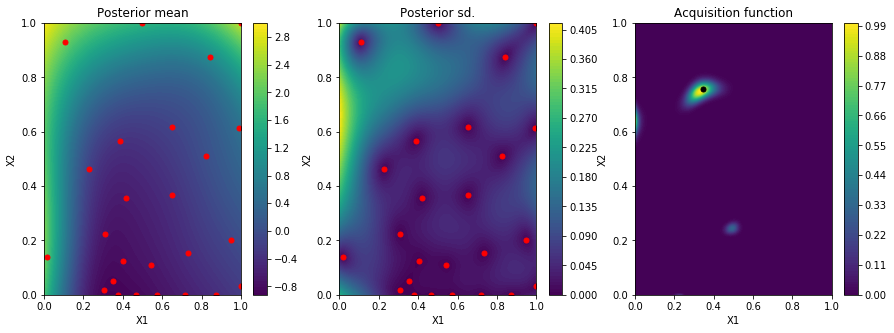

In [175]:
optimizer.plot_acquisition()

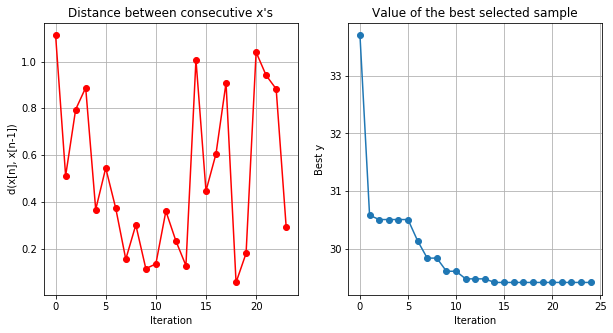

In [176]:
optimizer.plot_convergence()

In [177]:
optimizer.x_opt

array([0.37775204, 0.        ])

In [178]:
cv_score([optimizer.x_opt])

array(-29.41163547)

In [179]:
cv_score([np.array([.8, .5])])

array(-30.65905305)